## A Neural Network From Scratch

This project uses basic Python libraries (no TensorFlow, no PyTorch) to implement a neural network. The data is from the MNIST database which contains various "hand-drawn" images of digits, sourced from [Kaggle](https://www.kaggle.com/competitions/digit-recognizer). I did this to understand the fundamentals of machine learning and prepare myself for future coding projects. Let's start by importing the libraries and the data.

In [18]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

#### Loading the Data

The training dataset has 42000 rows (number of images) and 785 columns. The images are 28 x 28 pixels, for a total of 784 pixels. The additional column is for the label, identifying which digit that image represents. For a given pixel, we have a value from 0 - 255: 255 being completely white, and 0 being completely black. 

Training data is used to train the model, and testng data is only used once at the very end to estimate the model's performance on future data. In the next few code chunks, the data is loaded and prepared.

In [19]:
# Load in the data
data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

In [20]:
# A quick peek at the data
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Transformed from a pandas DataFrame to a 2D numpy array and shuffled
data = np.array(data)
images, inputs = data.shape
np.random.shuffle(data)

# Transposed so that one column represents one image, with 784 rows per image for pixels
data = data.T

# Take 20% of the training data as a validation set
data_train = data[:, 0:33600]
data_validation = data[:, 33600:]

# Labels split from data 
# Data normalized to represent pixels between 0 and 1
# For both datasets
Y_train = data_train[0]
X_train = data_train[1:inputs]/255

Y_val = data_validation[0]
X_val = data_validation[1:inputs]/255

#### Our Network Structure

We will construct a simple neural network with 3 layers. The input layer has 784 nodes (no parameters). The next layer is the hidden layer and has 10 nodes. The third layer is the output layer that also has 10 nodes. When data passes from one layer to the next, there is a weight and a bias (parameters) applied to transform the input.

**Input Layer**:
- A0 = X   
- Size: (784 x m)

**Hidden Layer**:
- Z1 = W1 * A0 + b1
- Sizes: 
    - Z1 (10 x m) this is the output of the hidden layer
    - W1 (10 x 784) this is the weight applied to the input
    - A0 (784 x m) this is the input
    - b1 (10 x 1) this is the bias applied

*Important Step*: We have to apply an activation function. Because if we did not have one, we would only have an output that is purely a linear combination of the input layer. This cannot give us very meaningful output.

We will use a **ReLU** activation function: Rectified Linear Unit. This is a linear function past 0 and a zero function everywhere else.
- A1 = g(Z1) = ReLU(Z1)

**Output Layer**
- Z2 = W2 * A1 + b2
- Sizes: 
    - Z2 (10 x m) this is the output of the output layer
    - W2 (10 x 784) this is the weight applied to the activated hidden layer output
    - A1 (784 x m) this is the activated output generated from the hidden layer
    - b2 (10 x 1) this is the bias applied

*Important Step*: We must again apply an activation function that will generate a more useful output from this data. Here we choose softmax, which calculates probabilities of the possible outputs from the raw output layer output data (Z2).

- A2 = softmax(Z2)

Let's code it up!

In [22]:
input_layer_size = 784 
hidden_layer_size = 10
output_layer_size = 10 

# Initializing random parameters to start
def initialize_params():
    W1 = np.random.randn(hidden_layer_size, input_layer_size) * np.sqrt(1 / input_layer_size)
    b1 = np.zeros((hidden_layer_size, 1))
    W2 = np.random.randn(output_layer_size, hidden_layer_size) * np.sqrt(1 / hidden_layer_size)
    b2 = np.zeros((output_layer_size, 1))
    return W1, b1, W2, b2

# We have to define a ReLU function before we can do forward propagation
def ReLU(Z):
    # This is element-wise, so for each element in Z, it will return either Z or 0 depending on which is larger
    return np.maximum(0, Z)

# Compute the softmax function
def softmax(Z):
    return (np.exp(Z)) / (np.sum(np.exp(Z), axis=0))

# Now let's apply the formulas and move forward through the network
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

# A cost function to calculate the loss, using cross-entropy here
def cross_entropy_loss(Y, Y_hat):
    loss = -np.mean(Y * np.log(Y_hat))
    return loss


#### Training our Network

Previously, we defined our network. And the formulas we defined above show how we traverse the network in a process known as **forward propagation**. Load in the data, apply weights and biases, and calculate an output. But in order to *train* the model to become better at identifying the digits, we have to check to see if we were right, and specifically, *how right*. This is the principle of **backwards propagation**. As the name suggests, we must essentially apply the inverse of forward propagation. We do this by calculating the error between our output values and the known values (the labels). We apply further formulas to calculate the error in the weights and biases as well. 

In [23]:
# Currently Y is in the format of a 1D array of values 
# For each value, turn it into a vector with a one in the location 
# of the value and zeros everywhere else
def one_hot_encode(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

# return 1 if Z > 0 (slope of y = x)
# return 0 if Z < 0 (slope of y = 0)
def der_ReLU(Z):
    return Z > 0

# Traverse backwards through the network and calculate errors
def back_prop(Z1, A1, Z2, A2, W2, X, Y):
    m = Y.size
    one_hot_Y = one_hot_encode(Y)

    # the error in the calculation of Z2 
    # (output layer intermediate output)
    dZ2 = A2 - one_hot_Y

    # the error in the calculation of W2
    # (the weight in the output layer)
    dW2 = (1/m) * dZ2.dot(A1.T)

    # the error in the calculation of b2
    # (the bias in the output layer)
    db2 = (1/m) * np.sum(dZ2, 1)
    db2 = db2.reshape(-1, 1)

    # the error in the calculation of Z1
    # (the output of the hidden layer)                        
    dZ1 = W2.T.dot(dZ2) * der_ReLU(Z1)

    # the error in the calculation of W1
    # (the weight in the hidden layer)
    dW1 = (1/m) * dZ1.dot(X.T)

    # the error in the calculation of b1
    # (the bias in the hidden layer)
    db1 = (1/m) * np.sum(dZ1, 1)
    db1 = db1.reshape(-1, 1)

    return dW1, db1, dW2, db2  

#### Updating our Network

From here, we've done most of the hard work. Now, we have to update the weights and biases based on our error calculations. The key part here is defining the learning rate **alpha**, a **hyperparameter**. Alpha defines how strong the updating is. An alpha closer to 1 means that any error highly changes the weights and biases, which can be useful for finding the right parameters but dangerous for causing instability. An alpha closer to 0 means that the values will converge more quickly but not always to the right value. 

In [24]:
# Update the weights and biases depending on the learning rate, alpha
def update(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 -= alpha * dW1
    b1 -= alpha * db1
    W2 -= alpha * dW2
    b2 -= alpha * db2
    return W1, b1, W2, b2

#### Gradient Descent

Gradient descent is an **optimization algorithm** - an iterative way to find the optimal weights and biases. This is the crux of the neural network and will use the methods we have previously defined. We start with initial random guesses for the parameters, and feed our training data through the network to calculate our outputs. We then backpropagate the outputs and quantify our error. Finally, we update the weights and biases based on that error. We run for a set number of iterations, and we **calculate our accuracy** (our output vs the actual labels) to understand how our model is performing. 

In [25]:
# Whichever value has the highest probability is the one that we select as the prediction
def get_predictions(A2):
    return np.argmax(A2, 0)

# How accurate we were overall
def get_accuracy(predictions, Y):
    return np.sum(predictions == Y)/Y.size

# Gradient descent
def gradient_descent(X, Y, iterations, alpha):
    # start with guesses for the weights and biases
    W1, b1, W2, b2 = initialize_params()
    for i in range(iterations):
        # travel forward through the network to calculate output matrices (activated and unactivated)
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)

        # feed those values back through the network and calculate the errors from the correct values that we know (using training data)
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W2, X, Y)

        # update the weights and biases based on the error that we calculated 
        W1, b1, W2, b2 = update(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)

        # print out the results
        if i % 250 == 0:
            print("Iteration # {}".format(i))
            print("Accuracy: {:.4f} ".format(get_accuracy(get_predictions(A2), Y)))
                            
    return W1, b1, W2, b2


#### Running the Model

Here is where we employ these techniques and optimize the model parameters with training data. We've specified some hyperparameters: **iterations** = 5000, **learning rate** = 0.1

In [26]:
# Run the gradient descent with 5000 iterations and a learning rate of 0.1
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 2500, alpha = 0.1)

Iteration # 0
Accuracy: 0.1016 


Iteration # 250
Accuracy: 0.8918 
Iteration # 500
Accuracy: 0.9076 
Iteration # 750
Accuracy: 0.9150 
Iteration # 1000
Accuracy: 0.9197 
Iteration # 1250
Accuracy: 0.9236 
Iteration # 1500
Accuracy: 0.9260 
Iteration # 1750
Accuracy: 0.9290 
Iteration # 2000
Accuracy: 0.9308 
Iteration # 2250
Accuracy: 0.9326 


#### Testing our Model

Now we test our model on the validation set. We observe **~93% accuracy**, wow! Our model earned an A in classifying digits!!

In [35]:
# Make and store image label predictions
def make_predictions(X, W1, b1, W2, b2):
    Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

# Show an example prediction
def test_prediction(i, W1, b1, W2, b2):
    image = X_train[:, i, None]
    prediction = make_predictions(image, W1, b1, W2, b2)
    label = Y_train[i]

    print("Our neural network thinks this is a: {}".format(prediction))
    print("This is labelled as a: {}".format(label))

    image = image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(image, interpolation="nearest")
    plt.show()

In [36]:
# Applying to validation set
Z1, A1, Z2, A2 = forward_prop(W1 = W1, b1 = b1, W2 = W2, b2 = b2, X = X_val)
preds = get_predictions(A2)
print("Accuracy: {:.4f} ".format(get_accuracy(preds, Y_val)))

Accuracy: 0.9223 


#### Final Predictions for Kaggle

Finally we can apply our model to the Kaggle testing data. We store our predictions in a .csv file and submit to the competition to see our results!

In [38]:
test_data = test_data.transpose()
results = make_predictions(test_data, W1, b1, W2, b2)
image_ids = np.arange(1, 28001, 1)

result_df = pd.DataFrame({'ImageId' : image_ids, 'Label': results})
result_df.to_csv('results.csv', index=False)

C:\Users\shivm\AppData\Local\Temp\ipykernel_5392\570977314.py:20: RuntimeWarning: overflow encountered in exp
  return (np.exp(Z)) / (np.sum(np.exp(Z), axis=0))
C:\Users\shivm\AppData\Local\Temp\ipykernel_5392\570977314.py:20: RuntimeWarning: invalid value encountered in divide
  return (np.exp(Z)) / (np.sum(np.exp(Z), axis=0))


#### Showcasing our Results

Let's see it in action! Here, I pull specific images from the training set and compare the model's output with the actual label. It's amazing to see how accurate it is. This has been a great way to explore my interest in machine learning, and I'm excited to start more projects!

Our neural network thinks this is a: [3]
This is labelled as a: 3


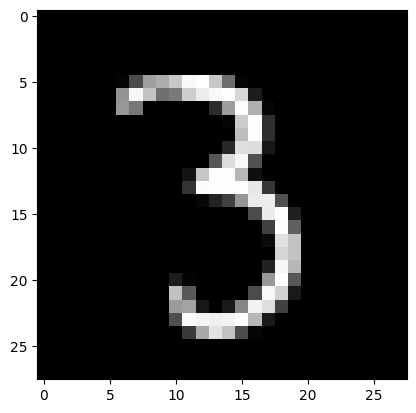

In [39]:
test_prediction(17, W1, b1, W2, b2)

Our neural network thinks this is a: [0]
This is labelled as a: 0


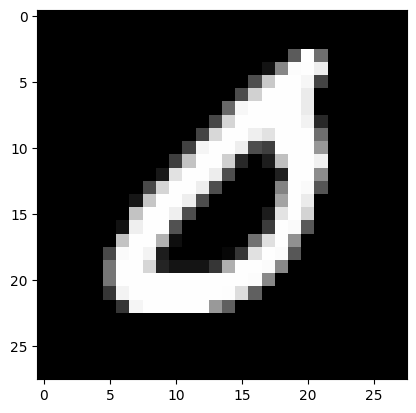

In [40]:
test_prediction(137, W1, b1, W2, b2)

Our neural network thinks this is a: [3]
This is labelled as a: 3


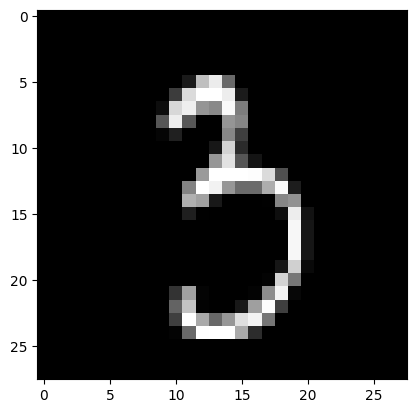

In [41]:
test_prediction(2314, W1, b1, W2, b2)

Our neural network thinks this is a: [9]
This is labelled as a: 9


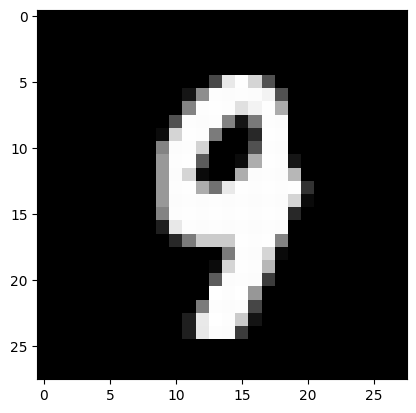

In [42]:
test_prediction(7391, W1, b1, W2, b2)

Our neural network thinks this is a: [3]
This is labelled as a: 3


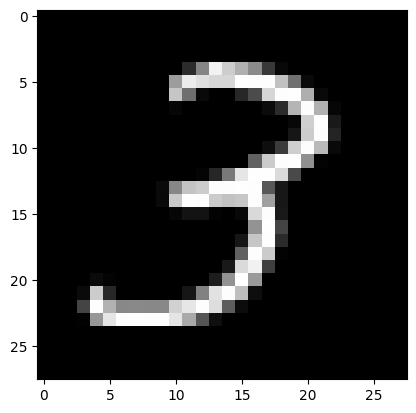

In [43]:
test_prediction(14713, W1, b1, W2, b2)